In [1]:
import os
import zipfile

# Criar pasta oculta .kaggle
os.makedirs("/root/.kaggle", exist_ok=True)

# Copiar kaggle.json para a pasta certa (ajuste o nome do arquivo se necessário)
!cp kaggle.json /root/.kaggle/

# Dar permissão
!chmod 600 /root/.kaggle/kaggle.json

In [2]:
!pip install kaggle
!kaggle datasets download -d orvile/brain-cancer-mri-dataset
!unzip /content/brain-cancer-mri-dataset.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: Brain_Cancer raw MRI data/Brain_Cancer/brain_glioma/brain_glioma_1058.jpg  
  inflating: Brain_Cancer raw MRI data/Brain_Cancer/brain_glioma/brain_glioma_1059.jpg  
  inflating: Brain_Cancer raw MRI data/Brain_Cancer/brain_glioma/brain_glioma_1060.jpg  
  inflating: Brain_Cancer raw MRI data/Brain_Cancer/brain_glioma/brain_glioma_1061.jpg  
  inflating: Brain_Cancer raw MRI data/Brain_Cancer/brain_glioma/brain_glioma_1062.jpg  
  inflating: Brain_Cancer raw MRI data/Brain_Cancer/brain_glioma/brain_glioma_1063.jpg  
  inflating: Brain_Cancer raw MRI data/Brain_Cancer/brain_glioma/brain_glioma_1064.jpg  
  inflating: Brain_Cancer raw MRI data/Brain_Cancer/brain_glioma/brain_glioma_1065.jpg  
  inflating: Brain_Cancer raw MRI data/Brain_Cancer/brain_glioma/brain_glioma_1066.jpg  
  inflating: Brain_Cancer raw MRI data/Brain_Cancer/brain_glioma/brain_glioma_1067.jpg  
  inflating: Brain_Cancer raw MRI data/Brain_Cancer

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pathlib

# Configurações iniciais
data_directory = pathlib.Path("Brain_Cancer raw MRI data/Brain_Cancer")
img_height, img_width = 224, 224
batch_size = 32

# Carregar datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_directory,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_directory,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("\nClasses detectadas:", class_names)

# Pré-processamento e cache
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Usar MobileNetV3Small - muito mais rápida que ResNet50
base_model = tf.keras.applications.MobileNetV3Small(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg',  # Global Average Pooling
    include_preprocessing=True
)

# Congelar TODAS as camadas
base_model.trainable = False

model = Sequential([
    base_model,
    layers.Dense(256, activation='relu'),  # Menos neurônios
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),  # Camada adicional menor
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compilar modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nResumo do modelo:")
model.summary()

# Callbacks avançados
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True,
    min_delta=0.001
)

checkpoint = ModelCheckpoint(
    'best_model_mobilenet.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Treinamento
print("\nTreinando com MobileNetV3")
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

# Avaliação final
print("\nAvaliação do modelo final:")
test_loss, test_acc = model.evaluate(validation_ds, verbose=2)
print(f"\nAcurácia na validação: {test_acc:.2%}")
print(f"Loss na validação: {test_loss:.4f}")

# Salvar modelo final
model.save('brain_cancer_classifier_mobilenet.keras')
print("\nModelo salvo como 'brain_cancer_classifier_mobilenet.keras'")

Found 6056 files belonging to 3 classes.
Using 4845 files for training.
Found 6056 files belonging to 3 classes.
Using 1211 files for validation.

Classes detectadas: ['brain_glioma', 'brain_menin', 'brain_tumor']
4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Resumo do modelo:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 576)            │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121,139 (4.28 MB)

 Trainable params: 181,507 (709.01 KB)

 Non-trainable params: 939,632 (3.58 MB)


Treinando com MobileNetV3
Epoch 1/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.7141 - loss: 0.6647
Epoch 1: val_loss improved from inf to 0.23386, saving model to best_model_mobilenet.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 98s 592ms/step - accuracy: 0.7147 - loss: 0.6635 - val_accuracy: 0.9216 - val_loss: 0.2339 - learning_rate: 0.0010
Epoch 2/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.8844 - loss: 0.3082
Epoch 2: val_loss improved from 0.23386 to 0.22316, saving model to best_model_mobilenet.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 123s 471ms/step - accuracy: 0.8844 - loss: 0.3081 - val_accuracy: 0.9191 - val_loss: 0.2232 - learning_rate: 0.0010
Epoch 3/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9103 - loss: 0.2495
Epoch 3: val_loss improved from 0.22316 to 0.20173, saving model to best_model_mobilenet.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 79s 519ms/step - accuracy: 0.9103 - loss: 0.2495 - val_accuracy: 0.9282 - val_loss: 0.2017 - learning_rate: 0.0010
Epoch 4/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.9165 - loss: 0.2324
Epoch 4: val_loss improved from 0.20173 to 0.18759, saving model to best_model_mobilenet.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 79s 519ms/step - accuracy: 0.9165 - loss: 0.2325 - val_accuracy: 0.9298 - val_loss: 0.1876 - learning_rate: 0.0010
Epoch 5/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9125 - loss: 0.2348
Epoch 5: val_loss improved from 0.18759 to 0.15578, saving model to best_model_mobilenet.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 80s 530ms/step - accuracy: 0.9125 - loss: 0.2348 - val_accuracy: 0.9430 - val_loss: 0.1558 - learning_rate: 0.0010
Epoch 6/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9196 - loss: 0.2081
Epoch 6: val_loss improved from 0.15578 to 0.15526, saving model to best_model_mobilenet.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 76s 504ms/step - accuracy: 0.9196 - loss: 0.2082 - val_accuracy: 0.9480 - val_loss: 0.1553 - learning_rate: 0.0010
Epoch 7/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9179 - loss: 0.2171
Epoch 7: val_loss did not improve from 0.15526
152/152 ━━━━━━━━━━━━━━━━━━━━ 72s 476ms/step - accuracy: 0.9179 - loss: 0.2171 - val_accuracy: 0.9422 - val_loss: 0.1604 - learning_rate: 0.0010
Epoch 8/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9164 - loss: 0.2097
Epoch 8: val_loss improved from 0.15526 to 0.14902, saving model to best_model_mobilenet.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 93s 546ms/step - accuracy: 0.9165 - loss: 0.2097 - val_accuracy: 0.9480 - val_loss: 0.1490 - learning_rate: 0.0010
Epoch 9/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9171 - loss: 0.2138
Epoch 9: val_loss improved from 0.14902 to 0.12888, saving model to best_model_mobilenet.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 76s 499ms/step - accuracy: 0.9171 - loss: 0.2138 - val_accuracy: 0.9571 - val_loss: 0.1289 - learning_rate: 0.0010
Epoch 10/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9208 - loss: 0.2080
Epoch 10: val_loss did not improve from 0.12888
152/152 ━━━━━━━━━━━━━━━━━━━━ 82s 538ms/step - accuracy: 0.9208 - loss: 0.2080 - val_accuracy: 0.9447 - val_loss: 0.1502 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 9.

Avaliação do modelo final:
38/38 - 15s - 387ms/step - accuracy: 0.9571 - loss: 0.1289

Acurácia na validação: 95.71%
Loss na validação: 0.1289

Modelo salvo como 'brain_cancer_classifier_mobilenet.keras'


In [ ]:
mobilenet_model.save("mobilenetv2_brain_cancer.keras")
print("Modelo salvo com sucesso!")


Modelo salvo com sucesso!


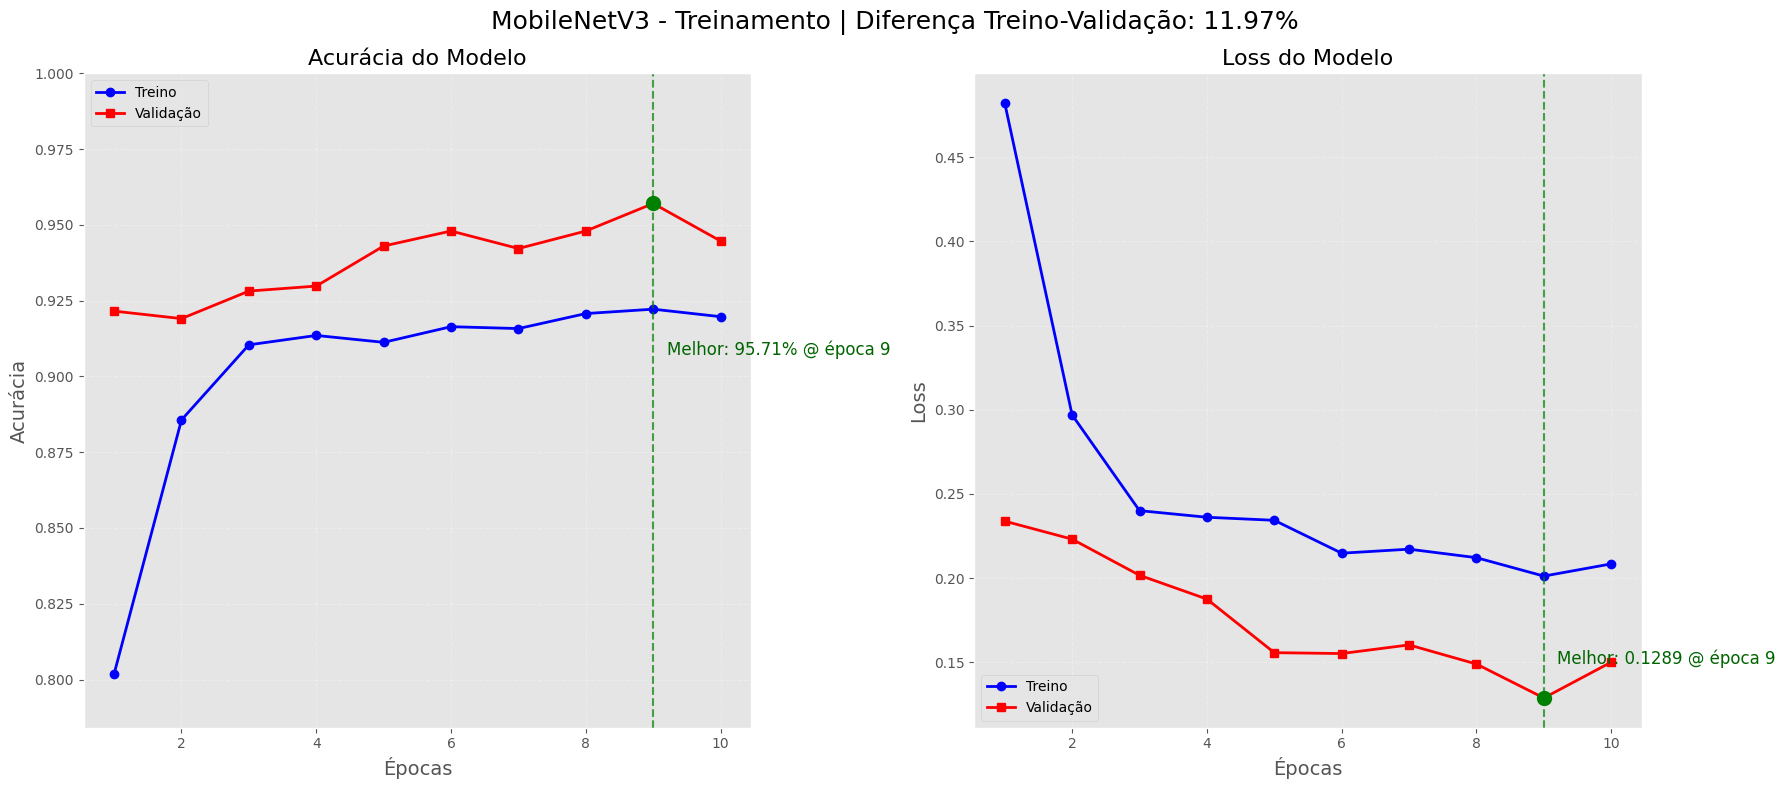

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history):
    # Preparar os dados
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Configuração do estilo
    plt.style.use('ggplot')
    plt.figure(figsize=(18, 8))

    # Gráfico de Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Treino', linewidth=2, markersize=6)
    plt.plot(epochs, val_acc, 'rs-', label='Validação', linewidth=2, markersize=6)

    # Detectar ponto de melhor validação
    best_epoch = np.argmax(val_acc) + 1
    best_acc = np.max(val_acc)
    plt.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7)
    plt.plot(best_epoch, best_acc, 'go', markersize=10)

    plt.title('Acurácia do Modelo', fontsize=16)
    plt.xlabel('Épocas', fontsize=14)
    plt.ylabel('Acurácia', fontsize=14)
    plt.ylim([min(plt.ylim()) - 0.01, 1.0])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.text(best_epoch + 0.2, best_acc - 0.05,
             f'Melhor: {best_acc:.2%} @ época {best_epoch}',
             fontsize=12, color='darkgreen')

    # Gráfico de Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Treino', linewidth=2, markersize=6)
    plt.plot(epochs, val_loss, 'rs-', label='Validação', linewidth=2, markersize=6)

    # Detectar ponto de menor loss
    best_epoch_loss = np.argmin(val_loss) + 1
    best_loss = np.min(val_loss)
    plt.axvline(x=best_epoch_loss, color='g', linestyle='--', alpha=0.7)
    plt.plot(best_epoch_loss, best_loss, 'go', markersize=10)

    plt.title('Loss do Modelo', fontsize=16)
    plt.xlabel('Épocas', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.text(best_epoch_loss + 0.2, best_loss + 0.02,
             f'Melhor: {best_loss:.4f} @ época {best_epoch_loss}',
             fontsize=12, color='darkgreen')

    # Análise de overfitting
    max_diff = np.max(np.abs(np.array(acc) - np.array(val_acc)))
    plt.suptitle(f'MobileNetV3 - Treinamento | Diferença Treino-Validação: {max_diff:.2%}',
                 fontsize=18, y=0.98)

    plt.tight_layout()
    plt.savefig('mobilenetv3_training.png', dpi=300, bbox_inches='tight')
    plt.show()

# Após o treino, chame a função com o histórico:
plot_training_history(history)